In [1]:
########## Adapted from https://github.com/osh/KerasGAN/blob/master/MNIST_CNN_GAN_v2.ipynb ###################

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducability

import keras.models as models
from keras.layers import Input
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
import keras.backend as K
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist

import seaborn as sns
import random, sys, os
from keras.models import Model
from IPython import display
from tqdm import tqdm

Using TensorFlow backend.
/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Set up parameters

In [2]:
dropout_rate = 0.25
opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
nch = 200

## Load data

In [3]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(np.min(X_train), np.max(X_train))
print('X_train shape:', X_train.shape, 'X_test.shape:', X_test.shape)

0.0 1.0
X_train shape: (60000, 28, 28, 1) X_test.shape: (10000, 28, 28, 1)


In [4]:
def plot_imgs(imgs, n_ex=16,dim=(4,4), figsize=(10,10)):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    imgs = imgs[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(imgs.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = imgs[i,:,:, 0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

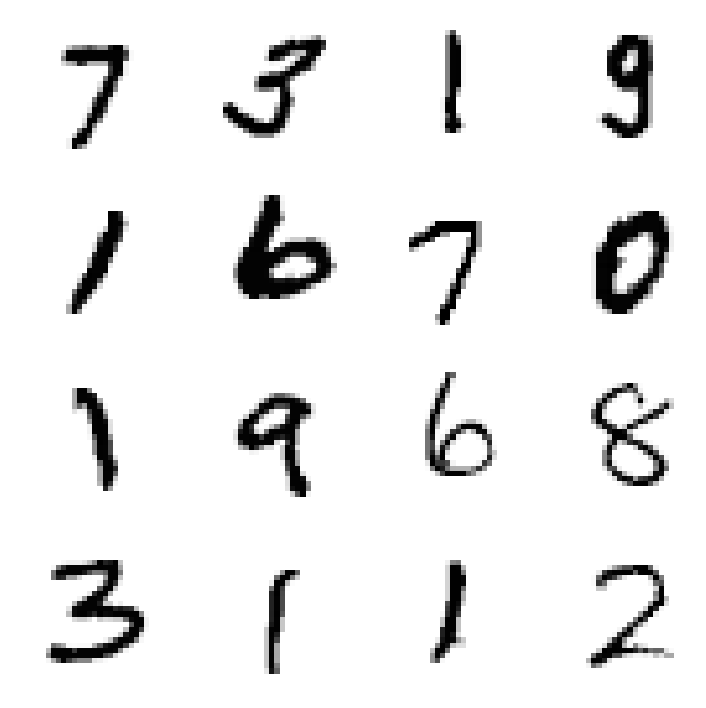

In [5]:
plot_imgs(X_train)

# Build model

In [10]:
def make_trainable(net, val):
    # net.trainable = val
    for l in net.layers:
        l.trainable = val

In [11]:
# Build Generative model ... only used for forward pass
g_input = Input(shape=[100])
H = Dense(nch*14*14, kernel_initializer='glorot_normal')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape([14, 14, nch])(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(nch//2, (3, 3), padding='same', kernel_initializer='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(nch//4, (3, 3), padding='same', kernel_initializer='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
# generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=X_train.shape[1:])
H = Convolution2D(256, (5, 5), strides=(2, 2), padding='same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, (5, 5), strides=(2, 2), padding='same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(11, activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
# Note that stand-alone discriminator will not be frozen as we are freezing after its compilation (although 
# summary will suggest it is - bug)
# but the discriminator part of the GAN will be frozen, and will remain so forever after GAN compilation.
make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_4 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_5 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 200)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 200)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 100)       180100    
__________

## Pre-train discriminator

In [12]:
n = 10000
trainidx = random.sample(range(0,X_train.shape[0]), n)
x_sample = X_train[trainidx,:,:,:]
y_sample = y_train[trainidx]

# Pre-train the discriminator network ...
# Note that discriminator not frozen even though summary suggests otherwise
noise_gen = np.random.uniform(0,1,size=[n,100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((x_sample, generated_images))
y = np.zeros([2*n,11])
for i in range(n):
    y[i, y_sample[i]] = 1
assert np.all(y_sample == np.argmax(y[:n], axis=1))
y[n:,10] = 1


# make_trainable(discriminator, True)
discriminator.fit(X,y, epochs=1, batch_size=32)

Epoch 1/1
20000/20000 [==============================] - 11s - loss: 0.2581     

## Test discriminator performance

In [13]:
y_hat = discriminator.predict(X)
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
acc = np.mean(y_idx==y_hat_idx)
print("Accuracy: {:0.02f}".format(acc))

Accuracy: 0.97


## Train GAN

In [14]:
def plot_loss(losses, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.show()

In [15]:
def plot_gen_out(generator, n_ex=16, dim=(4,4), figsize=(10,10)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def train_for_n(data, discriminator, generator, GAN, nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    X_train, y_train = data
    losses = {"d":[], "g":[]}
    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        trainidx = random.sample(range(0,X_train.shape[0]), BATCH_SIZE)
        x_sample = X_train[trainidx,:,:,:]
        y_sample = y_train[trainidx] 
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((x_sample, generated_images))
        y = np.zeros([2*BATCH_SIZE,11])
        for i in range(BATCH_SIZE):
            y[i, y_sample[i] = 1
        assert np.all(y_sample == np.argmax(y[:n], axis=1))
        y[BATCH_SIZE:,10] = 1
        
        # make_trainable(discriminator, True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,11])
        y2[:,1] = 1 # pretend fake images are real to fool generator
        
        # make_trainable(discriminator, False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            display.clear_output(wait=True)
            plot_loss(losses)
            plot_gen_out(generator)

    return losses        

In [ ]:
losses = train_for_n(X_train, discriminator, generator, GAN, nb_epoch=250, plt_frq=25,BATCH_SIZE=128)

## Train further with decreasing learning rates and increasing batch size

In [ ]:
K.set_value(opt.lr, 1e-4)
K.set_value(dopt.lr, 1e-5)
losses = train_for_n(X_train, discriminator, generator, GAN, nb_epoch=100, plt_frq=10,BATCH_SIZE=128)

In [ ]:
K.set_value(opt.lr, 1e-5)
K.set_value(dopt.lr, 1e-6)
losses = train_for_n(X_train, discriminator, generator, GAN, nb_epoch=100, plt_frq=10,BATCH_SIZE=256)

## Plot final losses and generator output

In [ ]:
plot_loss(losses)

In [ ]:
plot_gen_out(generator, 25,(5,5),(12,12))
plot_imgs(X_train, 25, (5, 5), (12, 12))  # compare with real examples